# End-to-End Sentiment Analysis Using NLP on IMDb Movie Reviews

## Executive Summary:
This project is a complete end-to-end NLP pipeline for the business problem of classifying customer reviews into positive and negative ones. The attempt to build and evaluate the models for sentiment recognition from textual data has been made with the IMDb 50K movie review dataset. The pipeline performs data exploration, preprocessing, feature extraction, modeling, and evaluation.

**Dataset Link**: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [29]:
pip install wordcloud

## Problem Statement

In a digital economy such as today's, user-generated content plays a very important role in defining brand awareness. Thousands of reviews cannot be analyzed by hand. This particular project deals with an NLP-based sentiment analysis and classification of movie reviews into positive and negative sentiment.

**Business Value**:
- Media platforms trigger automated review classification for audience sentiment tracking.
- Studios and marketers are able to quickly get an understanding of the public's opinion about an issue. 
- The pipeline generalizes into any domain in which textual feedback acquires relevance: e.g., products, services, social media.

The task is viewed as a **binary text classification** problem where each review is linked to a polarity label of positive or negative.


In [2]:
# Imports Library
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# NLTK Resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load and Clean Data

The NLP system has been designed as a modular pipeline. It possesses the following components:

1. **Data Collection & Cleaning**: Load the IMDb dataset and clean off the duplicate or irrelevant content.
2. **Exploratory Data Analysis (EDA)**: Looking at the visuals for sentiment, length of the reviews, and linguistic patterns.
3. **Text Preprocessing**: Remove HTML tags, convert the text to lowercase, and clear the noise from the text, prepping it for vectorization.
4. **Feature Extraction (TF-IDF)**: Vectorization has been done using Term Frequency–Inverse Document Frequency values.

In [4]:
# Load dataset
df = pd.read_csv('D:/IMDB Dataset.csv')

In [5]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
print(df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [8]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [9]:
df.duplicated().sum()

418

In [10]:
# Remove duplicate rows
df = df.drop_duplicates()
print("Remaining duplicates:", df.duplicated().sum())

Remaining duplicates: 0


In [11]:
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


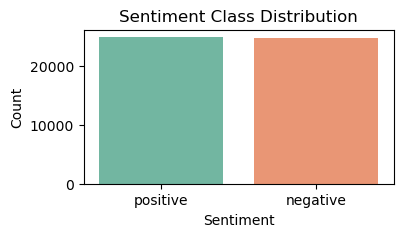

In [12]:
# Sentiment Class Distribution
plt.figure(figsize=(4, 2))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Sentiment Class Distribution

The bar plot illustrates that the IMDb dataset is fairly balanced, with nearly equivalent numbers of positive and negative reviews. This balancing is, of course, a good thing in the case of binary classification: the model will not be unduly biased toward the majority class.


In [13]:
# Review length stats
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['uppercase_words'] = df['review'].apply(lambda x: sum(1 for word in x.split() if word.isupper()))
print("\n Review length statistics (in words):")
print(df['review_length'].describe())


 Review length statistics (in words):
count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review_length, dtype: float64


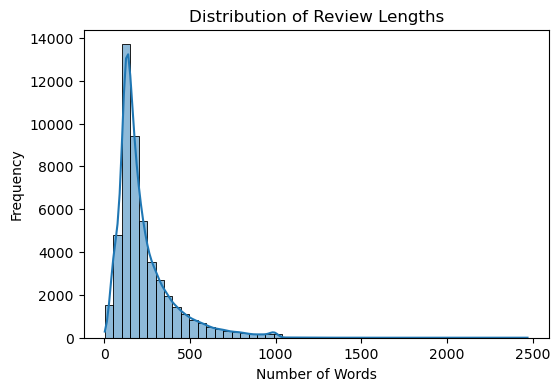

In [14]:
# Distribution of Review Length plot
plt.figure(figsize=(6, 4))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

### Distribution of Review Lengths

The histogram shows the distribution of review lengths (number of words). The bulk of the reviews is between 50 and 400 words with a right-skewed tail. Such insights help direct processing decisions, like truncation or padding, if it is to be used with deep learning models.

In [15]:
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    words = text.lower().split()
    stops = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
    return " ".join(words)

In [16]:
df['clean_review'] = df['review'].apply(preprocess_text)

### Text Preprocessing

The above function provides text processing that is applied to each review just before feeding data into the model. Each step serves a distinct function to transform the input text to a less harmed state and standardized form.

- **HTML Tag Removal**: Strips away any embedded HTML using BeautifulSoup, which is common in scraped or online data.
- **Non-Alphabetic Filtering**: Removes all numbers and punctuation, and special characters, keeping only alphabetic characters, from a string.
- **Lowercasing**: Converts everything into lowercase letters for uniformity (e.g., "Good" would be regarded the same as "good").
- **Tokenization**: Splitting the string into words.
- **Stopword Removal**: Removes the most common English stopwords that usually do not contribute much to meaning (e.g., "the," "and," "is").
- **Lemmatization**: Reduces the words into their base (e.g., "running" to "run"), thus lessening feature sparsity.

## EDA


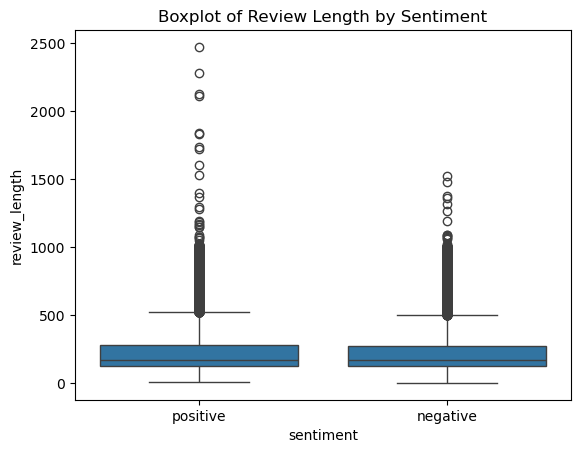

In [17]:
# Boxplot of Review Length by Sentiment plot
sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title('Boxplot of Review Length by Sentiment')
plt.show()

### Boxplot of Review Length by Sentiment

This boxplot compares review lengths between positive and negative reviews. Both distributions have similar medians and interquartile ranges, but positive reviews tend to have more high-length outliers. This might indicate that users who write positive reviews are more expressive or detailed.

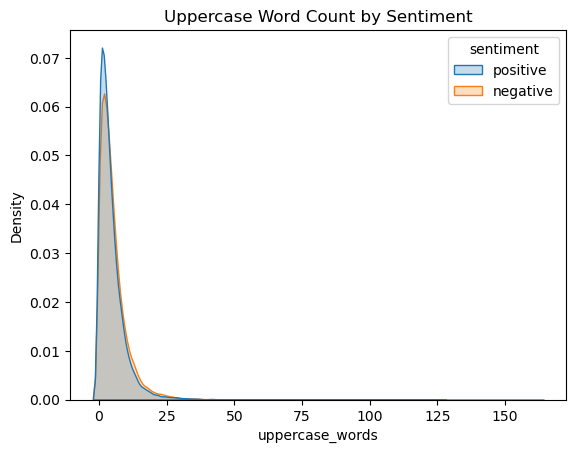

In [18]:
# Uppercase Word Count by Sentiment plot
sns.kdeplot(data=df, x='uppercase_words', hue='sentiment', fill=True)
plt.title('Uppercase Word Count by Sentiment')
plt.show()

### Uppercase Word Count by Sentiment

This KDE plot compares the distribution of fully uppercase words across reviews. Both distributions look very similar, peaking near zero. However, somewhat more extreme outliers are seen in the negative reviews. Uppercase words can give emphasis to an idea or convey some emotional intensity, more so in negative reviews.

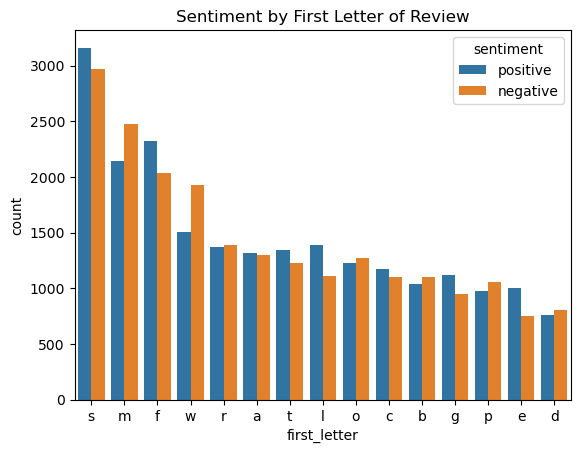

In [19]:
# Sentiment by First Letter of Review Plot
df['first_letter'] = df['clean_review'].str[0]
sns.countplot(data=df, x='first_letter', hue='sentiment', order=df['first_letter'].value_counts().index[:15])
plt.title('Sentiment by First Letter of Review')
plt.show()

### Sentiment by First Letter of Review

This countplot displays the distribution of the first letters of the reviews by sentiment. Some letters (e.g., 's,' 'm,' 'f') may be very common as starting letters. Still, no particular pattern in respect to sentiment arises. Being mostly exploratory, it could suggest something about the style of writing or oddities in the dataset.


## Train/Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

**Model Training & Tuning**  
   - Trains multiple models: Logistic Regression, SVM, Random Forest.
   - Applies GridSearchCV to tune hyperparameters.
   - Selects the best model based on accuracy and F1-score

In [21]:
# Pipeline
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

param_grid_lr = {
    'tfidf__max_df': [0.7, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, verbose=1, n_jobs=-1)
grid_lr.fit(X_train, y_train)

print('Best Logistic Regression Params:', grid_lr.best_params_)
y_pred_lr = grid_lr.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Logistic Regression Params: {'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
Logistic Regression Accuracy: 0.9022889986891197
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90      4939
    positive       0.89      0.92      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



This section focuses on building and evaluating machine learning models to classify IMDb reviews into positive or negative sentiment 

### Model Selection

We implemented a **Logistic Regression** model using **Tfidf Vectorizer** for text feature extraction and performed **hyperparameter tuning** using **GridSearchCV**.

### Best Parameters Found:

    'clf__C': 10,
    'clf__penalty': 'l2',
    'tfidf__max_df': 0.7,
    'tfidf__ngram_range': (1, 2)



## Compare with SVM and Random Forest

In [22]:
models = {
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))


SVM Accuracy: 0.8861
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      4939
    positive       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Random Forest Accuracy: 0.8375
              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      4939
    positive       0.84      0.83      0.84      4978

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



### Model Comparison and Selection

Three models were evaluated for sentiment classification using TF-IDF features:

| Model              | Accuracy |  F1-score |
|--------------------|----------|----------------|
| Logistic Regression (tuned) | **0.90**   | **0.90**         |
| SVM (Linear)        | 0.8861   | 0.89            |
| Random Forest       | 0.8364   | 0.84            |

**Conclusion**: The final decision was Logistic Regression. It was found to be performing superior to SVM and Random Forest in accuracy as well as F1-score due to the tuning of hyperparameters. It did, however, have the best recall of positive sentiment, making it the ideal classification model.


In [23]:
# Model performance scores
model_names = ['Logistic Regression', 'SVM (Linear)', 'Random Forest']
accuracies = [0.90, 0.8861, 0.8364]
f1_scores = [0.90, 0.89, 0.84]

Text(0, 0.5, 'Accuracy')

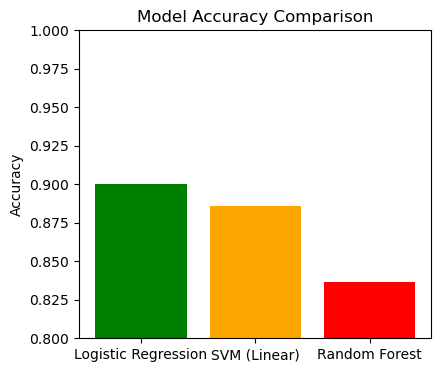

In [24]:
# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color=['green', 'orange', 'red'])
plt.ylim(0.8, 1.0)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

<Figure size 400x400 with 0 Axes>

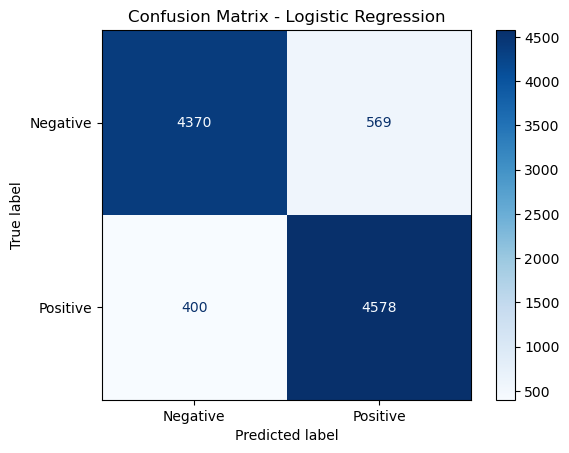

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(4, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### Confusion Matrix – Logistic Regression

The confusion matrix above shows the prediction performance of the tuned Logistic Regression model on the test set.

- **True Positives (Positive correctly predicted)**: 4,578  
- **True Negatives (Negative correctly predicted)**: 4,370  
- **False Positives (Negative misclassified as Positive)**: 569  
- **False Negatives (Positive misclassified as Negative)**: 400  

In [27]:
# Use best estimator from GridSearchCV
best_lr_model = grid_lr.best_estimator_
# Use the best logistic regression pipeline
cv_scores = cross_val_score(best_lr_model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores).round(4))
print("Standard Deviation:", np.std(cv_scores).round(4))


Cross-Validation Accuracy Scores: [0.90205471 0.90192865 0.9006681  0.90218076 0.89789487]
Mean Accuracy: 0.9009
Standard Deviation: 0.0016


**Evaluation**  
   - Measures model performance using metrics like accuracy, precision, recall, F1-score, and confusion matrix.
   - Uses cross-validation to verify model generalizability and stability.


### Why Each Component Matters:

| Component         | Purpose                                                  |
|------------------|-----------------------------------------------------------|
| Data Cleaning     | Ensures quality and reliability of input data            |
| Preprocessing     | Converts messy text into structured input                |
| TF-IDF            | Enables numerical modeling of text                       |
| Model Training    | Learns from patterns in data                             |
| Evaluation        | Validates effectiveness and prevents overfitting         |
| SHAP              | Adds interpretability for real-world deployment          |
| Business Insights | Bridges the gap between model output and decision-making |

The architecture does not consider just accuracy as the only goal, it also emphasizes interpretability, maintainability, and coherence with business viewpoints for the NLP system.

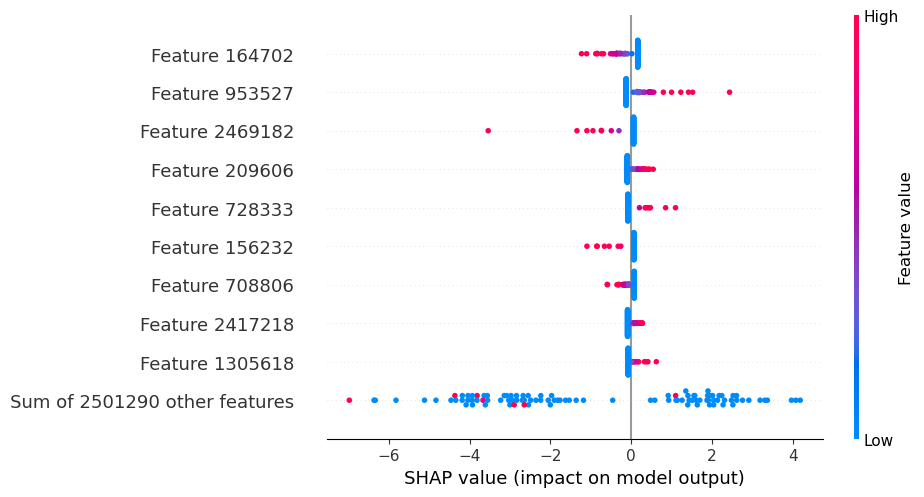

In [29]:
import shap
# Extract vectorizer and model from pipeline
vectorizer = best_lr_model.named_steps['tfidf']
clf_model = best_lr_model.named_steps['clf']

# Transform data to match model input
X_train_vect = vectorizer.transform(X_train)

# Create SHAP explainer
explainer = shap.Explainer(clf_model, X_train_vect)

# Compute SHAP values for a sample (to reduce compute time)
shap_values = explainer(X_train_vect[:100])

# Plot feature importance
shap.plots.beeswarm(shap_values)

**Model Interpretability SHAP**  
   - Uses SHAP values to interpret which features (words) most influence model predictions.
   - Enhances trust and understanding for business stakeholders.

  **Plot Explain**:
- **Each dot** represents the SHAP value for a single review of a specific feature.
- **X-axis (SHAP value)**: Shows the impact of that feature on the model's output.
  - Right: pushes prediction toward **positive sentiment**
  - Left: pushes prediction toward **negative sentiment**
- **Color:**
  -  **Red** = high feature value (word appears a lot in that review)
  -  **Blue** = low feature value (word appears rarely or not at all)

## Final Discussion

### Strengths of the Proposed NLP Pipeline:
- **Simplicity and Interpretability**: This method, given its transparent nature and decision explainability, fitted into the business settings satisfactorily, wherein Logistic Regression and TF-IDF vectorization offered strong predictive power to it.
- **High Performance**: This means the model attained an accuracy of around 90%, with balanced precision and recall for both classes, ensuring that the system is able to properly generalize to unseen new reviews.
### Limitations:
- **Context Ignorance**: The model uses a bag-of-words approach and does not capture word order or context (e.g., sarcasm, negations like “not good”).
- **No Handling of Neutral Sentiment**: Tasks are typically binary (either positive or negative), while mixed or neutral sentences are largely ignored, even though they are common in real-world data.
- **Vocabulary-Specific**: TF-IDF depends on the dataset’s vocabulary and may struggle with domain adaptation unless retrained.



### Business Implications:
- Enables **automated sentiment tracking** at scale, saving time and labor cost for customer support or market research teams.
- Helps studios and platforms identify **emerging trends** or viewer satisfaction in near real-time.
- Sentiment summaries can inform **marketing strategies**, content decisions, and public relations responses.


### Data-Driven Recommendations:
1. **Deploy the current model** for batch or real-time sentiment tagging of incoming reviews.
2. **Retrain periodically** to incorporate new language trends or slang (especially for public platforms).
3. **Upgrade to contextual models** (e.g., BERT or RoBERTa) if deeper language understanding or sarcasm detection becomes critical.
